<a href="https://colab.research.google.com/github/nabilaaaa24/Machine-Learning/blob/main/ML_Latihan_Modul_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
import random
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Prak ML/dataset_tweet_sentiment_opini_film.csv')
df

,Id,Sentiment,Text Tweet
0,1,negative,Jelek filmnya... apalagi si ernest gak mutu bg...
1,2,negative,Film king Arthur ini film paling jelek dari se...
2,3,negative,@beexkuanlin Sepanjang film gwa berkata kasar ...
3,4,negative,Ane ga suka fast and furious..menurutku kok je...
4,5,negative,"@baekhyun36 kan gua ga tau film nya, lu bilang..."
...,...,...,...
195,196,positive,Fargo juga adaptasi dari film yang cukup berha...
196,197,positive,637.000 waw ini sangat keren flm horor dng jum...
197,198,positive,@filmziarah film yang tenang dan menghanyutkan...
198,199,positive,Film yg amat menarik. Kisah cinta & kesetiaan ...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Id          200 non-null    int64 
 1   Sentiment   200 non-null    object
 2   Text Tweet  200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


## Augmentasi

In [ ]:
# Fungsi untuk mendapatkan sinonim dari sebuah kata
def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return list(set(synonyms))

In [ ]:
# Random Deletion
def random_deletion(words, p=0.1):
    if len(words) == 1:  # Jika teks hanya satu kata, tidak dihapus
        return words
    return [word for word in words if random.uniform(0, 1) > p]

In [ ]:
# Random Swap
def random_swap(words, n=1):
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return words

In [ ]:
# Random Insertion
def random_insertion(words, n=1):
    for _ in range(n):
        synonyms = []
        word = random.choice(words)
        synonyms = get_synonyms(word)
        if synonyms:
            words.insert(random.randint(0, len(words)), random.choice(synonyms))
    return words

In [ ]:
# Random Synonym Replacement
def random_synonym_replacement(words, n=1):
    words = words.copy()
    for _ in range(n):
        idx = random.randint(0, len(words) - 1)
        synonyms = get_synonyms(words[idx])
        if synonyms:
            words[idx] = random.choice(synonyms)
    return words

In [ ]:
# Embedding Perturbation - add small random noise to word embeddings to increase model robustness
def add_embedding_noise(embedding_matrix, noise_factor=0.01):
    noise = np.random.normal(0, noise_factor, embedding_matrix.shape)
    return embedding_matrix + noise

In [ ]:
# Fungsi untuk menerapkan augmentasi pada teks
def augment_text(text, p_delete=0.05, n_swap=1, n_insert=1, n_synonym=1):
    words = text.split()
    words = random_deletion(words, p=p_delete)
    words = random_swap(words, n=n_swap)
    words = random_insertion(words, n=n_insert)
    words = random_synonym_replacement(words, n=n_synonym)
    return ' '.join(words)

# Preprocessing

In [ ]:
X = df['Text Tweet']
y = df['Sentiment']

# Menerapkan augmentasi pada dataset
df['Text Augmented'] = df['Text Tweet'].apply(augment_text)

# Menyambungkan teks asli dengan teks augmentasi
X_augmented = pd.concat([df['Text Tweet'], df['Text Augmented']])
y_augmented = pd.concat([y, y])

# Encoding Sentiment menjadi numerik sebelum pembagian data
label_encoder = LabelEncoder()
y_augmented_encoded = label_encoder.fit_transform(y_augmented)

# Tokenisasi
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")  # Membatasi jumlah kata yang akan digunakan
tokenizer.fit_on_texts(X_augmented)
word_index = tokenizer.word_index

# Padding sequences
sequences_augmented = tokenizer.texts_to_sequences(X_augmented)
padded_sequences_augmented = pad_sequences(sequences_augmented, maxlen=20, padding='post')

# Membagi data menjadi set pelatihan dan pengujian
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(padded_sequences_augmented, y_augmented_encoded, test_size=0.2, random_state=42)

In [ ]:
# Pastikan y_train_aug dan y_test_aug bertipe float untuk kompatibilitas dengan model
y_train_aug = y_train_aug.astype('float32')
y_test_aug = y_test_aug.astype('float32')

In [ ]:
# Membuat Model
model = Sequential([
    Embedding(input_dim=1000, output_dim=16, input_length=10),
    Bidirectional(LSTM(32, return_sequences=True)),
    LSTM(16),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Kompile Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Melatih Model
history = model.fit(X_train_aug, y_train_aug, epochs=10, validation_data=(X_test_aug, y_test_aug))

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.4774 - loss: 0.6925 - val_accuracy: 0.5875 - val_loss: 0.6872
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6356 - loss: 0.6860 - val_accuracy: 0.6750 - val_loss: 0.6695
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7436 - loss: 0.6619 - val_accuracy: 0.7250 - val_loss: 0.6206
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8272 - loss: 0.5903 - val_accuracy: 0.8750 - val_loss: 0.4883
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9382 - loss: 0.4082 - val_accuracy: 0.9375 - val_loss: 0.3091
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9637 - loss: 0.2622 - val_accuracy: 0.9375 - val_loss: 0.2355
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9846 - loss: 0.1581 - val_accuracy: 0.9250 - val_loss: 0.2276
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9865 - loss: 0.1168 - val_accuracy: 0.9500 - 

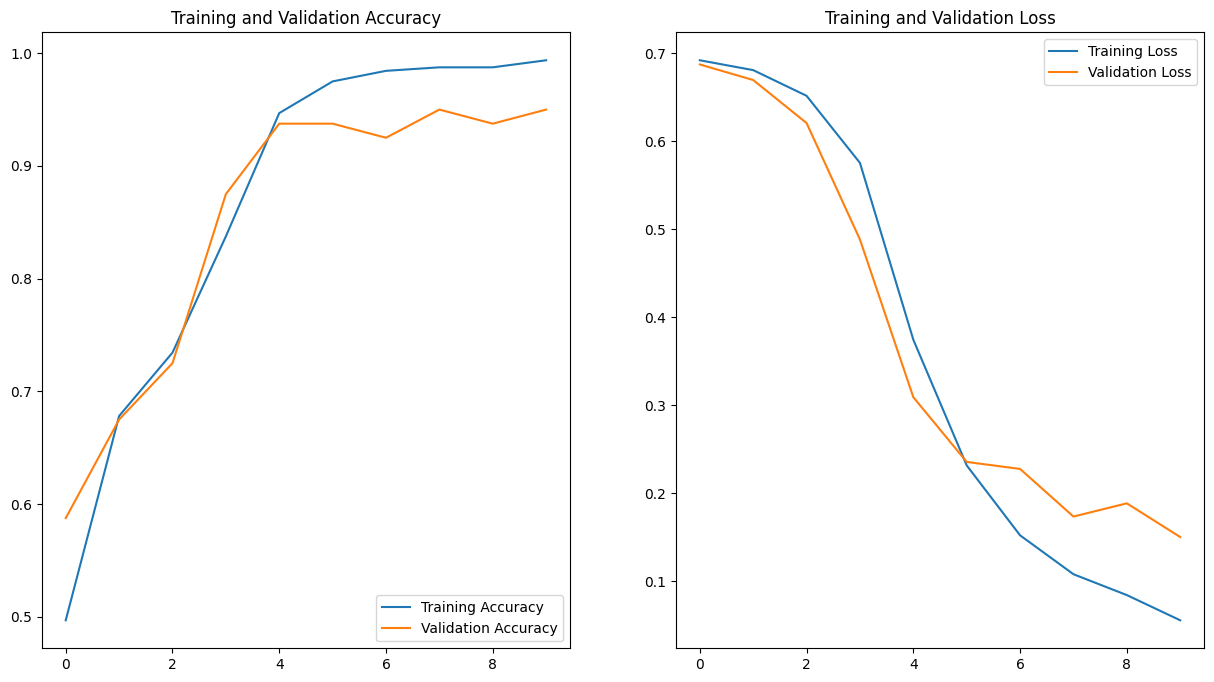

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(10), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), history.history['loss'], label='Training Loss')
plt.plot(range(10), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluasi Model
loss, accuracy = model.evaluate(X_test_aug, y_test_aug)
print(f"Accuracy setelah augmentasi: {accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9516 - loss: 0.1573 
Accuracy setelah augmentasi: 95.00%


In [ ]:
# Membuat prediksi pada data uji
y_pred_prob = model.predict(X_test_aug)
y_pred = (y_pred_prob > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step


In [ ]:
# Menampilkan classification report
print("\nClassification Report:")
print(classification_report(y_test_aug, y_pred, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

    negative       0.98      0.93      0.95        44
    positive       0.92      0.97      0.95        36

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



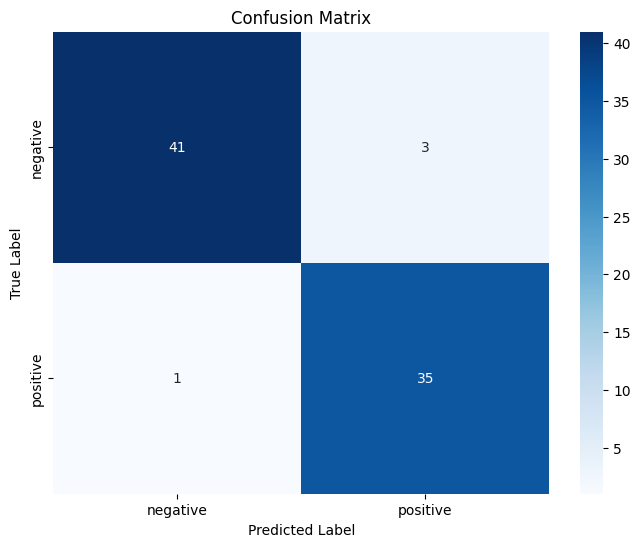

In [ ]:
conf_matrix = confusion_matrix(y_test_aug, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Prediksi pada data baru
new_texts = ["menyesal nontonnya, jelek banget", "alurnya bagus, tapi aktornya kurang cocok", "ceritanya oke, aktingnya juga bagus, mantap"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = pad_sequences(new_sequences, maxlen=20, padding='post')

predictions = model.predict(new_padded)
predicted_labels = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

for tweet, sentiment in zip(new_texts, predicted_labels):
    print(f"Tweet: '{tweet}' -> Prediksi Sentimen: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tweet: 'menyesal nontonnya, jelek banget' -> Prediksi Sentimen: negative
Tweet: 'alurnya bagus, tapi aktornya kurang cocok' -> Prediksi Sentimen: positive
Tweet: 'ceritanya oke, aktingnya juga bagus, mantap' -> Prediksi Sentimen: negative
